In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.datasets as ds
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.manual_seed(42)

In [38]:
VOCAB_SIZE = 3  # hyperparameter depending on the task
HEADS = 8
EMBED_DIM = 512
HEAD_DIM = EMBED_DIM // HEADS
D_PROB = 0.1

In [39]:
input_emb = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)
output_emb = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)

In [40]:
input_emb

Embedding(3, 512)

In [41]:
test = torch.LongTensor([[0, 1, 2], [2, 1, 0]])

In [42]:
do = input_emb(test)

## Head

In [43]:
key = nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)
query = nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)
value= nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)

# TODO: figure out register buffer
# TODO: prototype tril
register_buffer = ('mask', torch.tril(torch.ones(HEAD_DIM, HEAD_DIM), diagonal=1))

dropout = nn.Dropout(D_PROB)

# t for tokens, so I think this is words in this case
_, t, d_k = do.size() 
k = key(do)
q = query(do)
v = value(do)
qk = (q@k.transpose(-1, -2)) / d_k ** 0.5

mask = torch.tril(torch.ones(HEAD_DIM, HEAD_DIM))

# if mask:
qk = qk.masked_fill(mask[:t, :t] == 0, float('-inf'))

# 0 is among batches so ith, jth inputs in each batch add to 1, we don't want this
# 1 is through the columns, which is the word so maybe
# 2 is the word vector entirely
qk = F.softmax(qk, dim=-1)
attn = qk @ v

# dropout occurs at the end of the sublayer before adding residual connections and layernorming
attn
attn = dropout(attn)

In [44]:
from model import Head

In [45]:
head = Head(HEAD_DIM, EMBED_DIM, True)

## MultiHeadAttention

In [46]:
from model import MultiHeadAttention

In [47]:
mha = MultiHeadAttention(HEADS, HEAD_DIM, EMBED_DIM, mask=True)
multi = mha(do, do, do)

In [48]:
torch.all(multi == do).item(), multi.size() == do.size() # we want this

(False, True)

## FeedForward

In [49]:
from model import FeedForward

In [50]:
ff = FeedForward(EMBED_DIM)
ff(multi).size()

torch.Size([2, 3, 512])

In [51]:
multi.size()

torch.Size([2, 3, 512])

## Encoder Block

In [52]:
from model import EncoderBlock

In [53]:
eb = EncoderBlock(HEADS, EMBED_DIM)
enc = eb(do)

In [54]:
enc.size()

torch.Size([2, 3, 512])

## Decoder Block

In [55]:
from model import DecoderBlock

In [56]:
db = DecoderBlock(HEADS, EMBED_DIM)
db(do, enc).size()

torch.Size([2, 3, 512])

## Positional Encodings

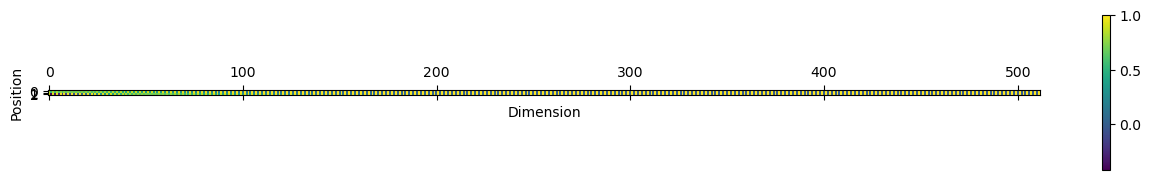

In [57]:
def pos_encoding(max_len, d_model):
    encoding = torch.zeros(max_len, d_model)
    pow = 2 * torch.arange(0, d_model//2) / d_model
    denom = 10_000 ** pow
    pos = torch.arange(0, max_len).view(-1, 1)
    encoding[:, ::2] = torch.sin(pos/denom)
    encoding[:, 1::2] = torch.cos(pos/denom)
    return encoding

def plot_positional_encoding(pos_enc):
    cax = plt.matshow(pos_enc.squeeze().numpy())
    plt.gcf().colorbar(cax)
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.show()

# Example usage
max_len = 3
d_model = 512  # Adjust the dimensionality as needed
pos_enc = pos_encoding(max_len, d_model)
plot_positional_encoding(pos_enc)

## Transformer

In [58]:
from model import Transformer

In [59]:
VOCAB_SIZE = 300  # hyperparameter depending on the task
HEADS = 8
EMBED_DIM = 512
HEAD_DIM = EMBED_DIM // HEADS
CONTEXT = 10
BATCH = 10
D_PROB = 0.1

In [60]:
optimus = Transformer(6, HEADS, EMBED_DIM, VOCAB_SIZE, CONTEXT)

In [61]:
pool = torch.randint(0, VOCAB_SIZE, (BATCH, CONTEXT+1))
x = pool[:, :CONTEXT]
trg = pool[:, 1:]
y = pool[:, 1:]
out = optimus(x, trg)

In [62]:
B, T, C = out.size()

In [63]:
out.view(B*T, C).size()

torch.Size([100, 300])

In [64]:
x.size(), y.size()

(torch.Size([10, 10]), torch.Size([10, 10]))

In [65]:
y.reshape(B*T)

tensor([258, 225,  11, 133, 151, 211, 115, 295,  77,  42, 265, 225,  38,   1,
         52, 218, 103, 283,  87,   5,  64, 189,  93,  65, 294, 173, 262,  13,
        279, 110, 214,  55, 168, 251, 203, 137, 273, 244,  25, 192, 197,  32,
          4, 108, 186, 136,  76, 247, 245, 261,  21, 111,  86, 113,  42,  13,
        139,  79, 262, 146, 153, 273, 227, 198,  95, 218, 279, 267,  67, 210,
        213, 283,  15, 129, 129, 215, 251, 275, 125,  34, 181, 285,  30, 259,
        268,  73, 237,  45, 268,  92, 162, 210,   8,  97, 175, 129,  77, 166,
        156, 116])

In [66]:
F.cross_entropy(out.view(B*T, C), y.reshape(B*T))

tensor(5.7311, grad_fn=<NllLossBackward0>)

## Dataset (HuggingFace)

In [67]:
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories")

ConnectionError: Couldn't reach 'roneneldan/TinyStories' on the Hub (ConnectionError)